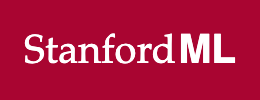

In [1]:
# MRNet-AlexNet - Multi-plane classifier: Axial + Sagittal + Coronal (GradCAM explainer)
# Author: Fernandez Hernandez, Alberto
# Date  : 2022 - 01 - 28

In [2]:
!nvidia-smi

Sun Jan 30 08:43:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# Libraries
from   matplotlib              import pyplot as plt
from   matplotlib.animation    import PillowWriter
from   google.colab            import drive
from   torch.utils             import data
from   sklearn                 import metrics
from   tqdm                    import tqdm
import torchvision.models      as models
import torchvision.transforms  as T
import tensorflow.compat.v1    as tf
tf.disable_v2_behavior()
import matplotlib.animation    as animation
import imgaug.augmenters       as iaa
import torch.nn                as nn
import pandas                  as pd
import numpy                   as np
import torch
import cv2
import os

torch.__version__, tf.__version__

('1.10.0+cu111', '2.7.0')

In [7]:
# Mount Goodgle Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# CUDA Device setup
# WARNING! DO NOT RUN THIS CHUNK UNLESS YOU WANT TO FIT ON GPU
# 1. Choose computer device: 0 -> GPU ; 1 -> GPU1 ; -1 -> CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# 2. Choose % GPU usage
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
# 3. Open a tensorflow session with these settings
sess        = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [10]:
# Constants
MRNET_PATH           = '/content/drive/MyDrive/Personal/Stanford_Knee_Dataset/MRNet-v1.0/'
TRAIN_PATH           = '/content/drive/MyDrive/Personal/Stanford_Knee_Dataset/MRNet-v1.0/train/'
VAL_PATH             = '/content/drive/MyDrive/Personal/Stanford_Knee_Dataset/MRNet-v1.0/valid/'
BATCH_SIZE           = 1
RANDOM_STATE         = 1234
EPOCHS               = 50
PATIENT              = 10
LOSS_IMPROVE         = 1e-04
# Source: https://www.serme.es/wp-content/uploads/2021/04/IA.-DIAGNOSIS-KNEE_compressed.pdf
MAX_PIXEL_VALUE      = 255

# Specify seeds for reproducibility
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True

In [14]:
# -- Load Stanford MRI Dataset
train_df_abnormal   = pd.read_csv(MRNET_PATH + 'train-abnormal.csv', header=None)
train_df_acl        = pd.read_csv(MRNET_PATH + 'train-acl.csv', header=None)
train_df_meniscus   = pd.read_csv(MRNET_PATH + 'train-meniscus.csv', header=None)

valid_df_abnormal   = pd.read_csv(MRNET_PATH + 'valid-abnormal.csv', header=None)
valid_df_acl        = pd.read_csv(MRNET_PATH + 'valid-acl.csv', header=None)
valid_df_meniscus   = pd.read_csv(MRNET_PATH + 'valid-meniscus.csv', header=None)

train_df            = pd.concat([train_df_abnormal, train_df_acl[1], train_df_meniscus[1]],
                                axis=1).drop_duplicates()
valid_df            = pd.concat([valid_df_abnormal, valid_df_acl[1], valid_df_meniscus[1]],
                                axis=1).drop_duplicates()
train_df.columns    = ['Image', 'Abnormal', 'ACL', 'Meniscus']
valid_df.columns    = ['Image', 'Abnormal', 'ACL', 'Meniscus']

pd.concat([train_df, valid_df], axis=0).reset_index(drop=True).to_csv(MRNET_PATH +\
                                                                      '/knee_metadata.csv')

# Load data and transform to data loader

In [15]:
# Step 1. Define MRDataset class
class MRDataset(data.Dataset):
    def __init__(self, transform=False, train=True, train_index_limit=1130):
        super().__init__()
        self.transform = transform
        self.train     = train
        self.records   = pd.read_csv(
                            MRNET_PATH + '/knee_metadata.csv'
                         )
        self.train_index_limit = train_index_limit
        # Define the three planes to use
        self.planes=['axial', 'sagittal', 'coronal']
        # An empty dictionary
        self.image_path={}
        
        if self.train:
            for plane in self.planes:
                # For each plane, specify the image path
                self.image_path[plane] = TRAIN_PATH + '/{0}/'.format(plane)
            self.records     = self.records.iloc[0:self.train_index_limit,:]
        else:
            for plane in self.planes:
                # Read path of images for each plane
                self.image_path[plane] = VAL_PATH + '/{0}/'.format(plane)
            self.records     = self.records.iloc[self.train_index_limit:,:]
            
        self.records['Image'] = self.records['Image'].map(
            lambda i: '0' * (4 - len(str(i))) + str(i))
        
        # Empty dictionary
        self.paths={}
        for plane in self.planes:
            # Get paths of numpy data files for each plane
            self.paths[plane] = [self.image_path[plane] + filename +
                          '.npy' for filename in self.records['Image'].tolist()]

        self.labels = self.records[['Abnormal', 'ACL', 'Meniscus']].values
        
        # Label weights (pos and neg)
        weights_ = []
        for disease in list(range(0,3)):
            pos = sum(self.labels[:,disease])
            neg = len(self.labels[:,disease]) - pos
            weights_.append(neg/pos)
        self.weights = torch.FloatTensor(weights_)

    def __len__(self):
        """Return the total number of images in the dataset."""
        return len(self.records)

    def __getitem__(self, index):
        # Data augmentation
        transform = iaa.Sequential([
                    iaa.Fliplr(0.5),
                    iaa.Affine(
                        translate_percent={"x": (-0.11, 0.11), 
                                           "y": (-0.11, 0.11)},
                        scale={"x": (1, 1.2), "y": (1, 1.2)},
                        rotate=(-10, 10)
            )
        ])
        
        img_raw = {}
        for plane in self.planes:
            # Load raw image data for each plane
            img_raw[plane] = np.load(self.paths[plane][index])
            # Normalize between 0 and 1
            img_raw[plane] = (img_raw[plane]) / MAX_PIXEL_VALUE
            # Resize the image loaded in the previous step
            if self.transform:
                img_raw_transformed = transform(images=img_raw[plane])
                img_raw[plane]      = np.stack((img_raw_transformed,)*3, axis=1)
            else:
                img_raw[plane] = np.stack((img_raw[plane],)*3, axis=1)
                
            img_raw[plane] = torch.FloatTensor(img_raw[plane])
            
        label = self.labels[index]
        label = torch.FloatTensor(label)
        
        # Return a list of three images for three planes and the label of the record
        return [img_raw[plane] for plane in self.planes], label

In [16]:
# Get dataset
train_dataset = MRDataset(transform=True)
val_dataset   = MRDataset(train=False)

In [17]:
train_loader = torch.utils.data.DataLoader(
                train_dataset, batch_size=BATCH_SIZE,
                shuffle=True, drop_last=False, num_workers=2)

val_loader  =  torch.utils.data.DataLoader(
                val_dataset, batch_size=BATCH_SIZE, 
                shuffle=False, drop_last=False, num_workers=2)

# Build Conv. model (pre-trained Alexnet)

In [44]:
# Step 2. Build Conv2D model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Build 2D model
        # IMPORTANT: Input shape of torch model must be (N,C,H,W) -> BatchSize, Channel, Heigth, Width
        # 3 pre-trained alexnet models (one for each plane)
        self.axial     = models.alexnet(pretrained=True, progress=False).features
        self.sagittal  = models.alexnet(pretrained=True, progress=False).features
        self.coronal   = models.alexnet(pretrained=True, progress=False).features
        
        # Disect the networks to access their last convolutional layer
        self.features_conv_axial    = self.axial[:12]
        self.features_conv_sagittal = self.sagittal[:12]
        self.features_conv_coronal  = self.coronal[:12]
        
        # Get the max pool of the features stem
        self.max_pool    = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
            
        self.avg_pool_axial     = nn.AdaptiveAvgPool2d(1)
        self.avg_pool_sagittal  = nn.AdaptiveAvgPool2d(1)
        self.avg_pool_coronal   = nn.AdaptiveAvgPool2d(1)
        
        # Placeholders for the gradients
        self.gradients_axial    = None
        self.gradients_sagittal = None
        self.gradients_coronal  = None
        
        # Finally, define 3-outputs-dense layer
        self.fc = nn.Sequential(
            nn.Linear(in_features=3 * 256, out_features=3)
        )
    
    # Hook for the gradients of the activations
    # Axial
    def activations_hook_axial(self, grad):
        self.gradients_axial = grad
    # Sagittal
    def activations_hook_sagittal(self, grad):
        self.gradients_sagittal = grad
    # Coronal
    def activations_hook_coronal(self, grad):
        self.gradients_coronal = grad
    
    def forward(self, x):
        # Remove first dimension for each image (on each plane)
        images = [torch.squeeze(img, dim=0) for img in x]
        # Extract features from alexnet models
        image1 = self.features_conv_axial(images[0])
        image2 = self.features_conv_sagittal(images[1])
        image3 = self.features_conv_coronal(images[2])
        
        # Register the hook (for each plane)
        h_axial    = image1.register_hook(self.activations_hook_axial)
        h_sagittal = image2.register_hook(self.activations_hook_sagittal)
        h_coronal  = image3.register_hook(self.activations_hook_coronal)
        
        # Apply remaining pooling (MaxPool2d & AdaptiveAvgPool2d)
        image1 = self.max_pool(image1)
        image2 = self.max_pool(image2)
        image3 = self.max_pool(image3)
        
        # Convert image dimension from [slices, 256, 1, 1] to [slices, 256]
        image1 = self.avg_pool_axial(image1).view(image1.size(0), -1)
        image2 = self.avg_pool_sagittal(image2).view(image2.size(0), -1)
        image3 = self.avg_pool_coronal(image3).view(image3.size(0), -1)
        
        # Find maximum value across slices, reducing images to [1, 256]
        image1 = torch.max(image1, dim=0, keepdim=True)[0]
        image2 = torch.max(image2, dim=0, keepdim=True)[0]
        image3 = torch.max(image3, dim=0, keepdim=True)[0]
        
        # Stack 3 images together
        output = torch.cat([image1, image2, image3], dim=1)
        
        # Feed the output to last dense layer
        output = self.fc(output)
        return output
    
    # Method for the gradient extraction
    def get_activations_gradient(self):
        return [self.gradients_axial, self.gradients_sagittal, self.gradients_coronal]
    
    # Method for the activation extraction
    def get_activations(self, x):
        images = [torch.squeeze(img, dim=0) for img in x]
        return [self.features_conv_axial(images[0]), 
                self.features_conv_sagittal(images[1]), 
                self.features_conv_coronal(images[2])]

In [19]:
model = CNNModel()
for param in model.parameters():
    print(param.size())

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


torch.Size([64, 3, 11, 11])
torch.Size([64])
torch.Size([192, 64, 5, 5])
torch.Size([192])
torch.Size([384, 192, 3, 3])
torch.Size([384])
torch.Size([256, 384, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([64, 3, 11, 11])
torch.Size([64])
torch.Size([192, 64, 5, 5])
torch.Size([192])
torch.Size([384, 192, 3, 3])
torch.Size([384])
torch.Size([256, 384, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([64, 3, 11, 11])
torch.Size([64])
torch.Size([192, 64, 5, 5])
torch.Size([192])
torch.Size([384, 192, 3, 3])
torch.Size([384])
torch.Size([256, 384, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([3, 768])
torch.Size([3])


In [20]:
# Define error criterion and optimize functions
train_criterion = nn.BCEWithLogitsLoss(pos_weight = train_dataset.weights)
val_criterion   = nn.BCEWithLogitsLoss(pos_weight = val_dataset.weights)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-05)
# Define callbacks
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, patience=3, factor=0.3, threshold=1e-4, verbose=True)

In [21]:
# Get Sensitivity-Specificity metrics
# Source: https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/
def get_sensitivity_specificity(y_true, y_pred):
    abnormal_true = list(map(lambda x: x[0], y_true))
    abnormal_pred = list(map(lambda x: x[0], y_pred))
    
    ACL_true      = list(map(lambda x: x[1], y_true))
    ACL_pred      = list(map(lambda x: x[1], y_pred))
    
    meniscus_true = list(map(lambda x: x[2], y_true))
    meniscus_pred = list(map(lambda x: x[2], y_pred))

    tn_ab, fp_ab, fn_ab, tp_ab     = metrics.confusion_matrix(abnormal_true, abnormal_pred).ravel()
    tn_acl, fp_acl, fn_acl, tp_acl = metrics.confusion_matrix(ACL_true, ACL_pred).ravel()
    tn_men, fp_men, fn_men, tp_men = metrics.confusion_matrix(meniscus_true, meniscus_pred).ravel()
    sensitivity = [round(tp_ab / (tp_ab+fn_ab), 4), round(tp_acl / (tp_acl+fn_acl), 4), round(tp_men / (tp_men+fn_men), 4)]
    specificity = [round(tn_ab / (tn_ab+fp_ab), 4), round(tn_acl / (tn_acl+fp_acl), 4), round(tn_men / (tn_men+fp_men), 4)]
    return sensitivity, specificity

In [22]:
# Define train function
def train(train_data, model, criterion):
    print('Training...')
    model.train()
    counter = 0
    correct = 0
    train_running_loss  = 0.0
    total               = 0.0
    prediction_list     = []
    for input_data, label in tqdm(train_data):
        # Switch to GPU if available
        if torch.cuda.is_available():
            input_data, label = [data.cuda() for data in input_data], label.cuda()
        counter += 1
        optimizer.zero_grad()
        outputs = model(input_data)

        # Apply sigmoid activation to get all the outputs between 0 and 1
        outputs_sig  = torch.sigmoid(outputs)
        predicted    = torch.round(outputs_sig)
        prediction_list.append(list(predicted.cpu().detach().numpy())[0])
        total       += label.size(1)
        
        # Accuracy (labels correctly classified)
        correct += (np.array(predicted.cpu().detach().numpy())[0]\
                    == np.array(label.cpu().detach().numpy())[0]).sum().item()
        
        # Loss
        loss     = criterion(outputs.cpu(), label.cpu())
        train_running_loss += loss.item()
        # Backpropagation
        loss.backward()
        # Update optimizer parameters
        optimizer.step()
    train_accuracy   = correct / total
    train_loss       = train_running_loss  / counter
    return train_loss, train_accuracy, prediction_list

In [42]:
# Define val function
def val(val_data, model, criterion):
    print('Validating...')
    model.eval()
    counter = 0
    correct = 0
    val_running_loss = 0.0
    total            = 0.0
    prediction_list  = []
    label_list       = []
    # with torch.no_grad():
    for input_data, label in tqdm(val_data):
        # Again, switch to GPU if available
        if torch.cuda.is_available():
            input_data, label = [data.cuda() for data in input_data], label.cuda()
        counter += 1
        outputs  = model(input_data)
        # Apply sigmoid activation to get all the outputs between 0 and 1
        outputs_sig = torch.sigmoid(outputs)
        predicted   = torch.round(outputs_sig)

        prediction_list.append(list(predicted.cpu().detach().numpy())[0])
        label_list.append(list(label.cpu().detach().numpy())[0])
        total    += label.size(1)

        # Accuracy (labels correctly classified)
        correct += (np.array(predicted.cpu().detach().numpy())[0]\
                == np.array(label.cpu().detach().numpy())[0]).sum().item()

        # Loss
        loss     = criterion(outputs.cpu(), label.cpu())
        val_running_loss += loss.item()

    val_accuracy = correct / total
    val_loss     = val_running_loss / counter
    # Get Sensitivity/Specificity
    sensitivity, specificity  = utils.get_sensitivity_specificity(label_list, prediction_list) 
    return val_loss, val_accuracy, prediction_list, sensitivity, specificity

In [ ]:
# start the training and validation
train_loss     = []
train_accuracy = []
valid_loss     = []
valid_accuracy = []
total_train_predictions = []
total_val_predictions   = []

best_val_loss = float('inf')
best_val_auc  = float(0)

patient_counter = 0

if torch.cuda.is_available():
    model = model.cuda()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_epoch_accuracy, train_predictions = train(
        train_loader, model, train_criterion
    )
    val_epoch_loss, val_epoch_accuracy, val_predictions, val_sensitivity, val_specificity = val(
        val_loader, model, val_criterion
    )
    
    # Call ReduceLR Callback (after validation step)
    scheduler.step(val_epoch_loss)
    
    if best_val_loss - val_epoch_loss >= LOSS_IMPROVE:
        print("Val loss has improved. From {} to {}. Saving model...".format(best_val_loss, val_epoch_loss))
        best_val_loss   = val_epoch_loss
        patient_counter = 0
        torch.save(model, f'{MRNET_PATH}/models/multiplane_grad_cam_models/mrnet_three_pretrained_models_non_frozen_weights_standarized_img_aug_gradcam_2022_01_28.pth')
    else:
        print("Val loss did not improve")
        patient_counter+=1
        if patient_counter == PATIENT:
            break
        
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    valid_loss.append(val_epoch_loss)
    valid_accuracy.append(val_epoch_accuracy)
    total_train_predictions.append(train_predictions)
    total_val_predictions.append(val_predictions)
    print(f"Train Accuracy: {train_epoch_accuracy:.4f}")
    print(f'Val Accuracy: {val_epoch_accuracy:.4f}')
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')
    print("Val-Sensitivity. Abnormal : {}, ACL: {}, Meniscus: {}".format(val_sensitivity[0], val_sensitivity[1], val_sensitivity[2]))
    print("Val-Specifity.   Abnormal : {}, ACL: {}, Meniscus: {}".format(val_specificity[0], val_specificity[1], val_specificity[2]))
    print("-"*80)

Epoch 1 of 50
Training...


100%|██████████| 1130/1130 [01:49<00:00, 10.34it/s]


Validating...


100%|██████████| 120/120 [00:07<00:00, 15.96it/s]
/data/dss_data/code-envs/python/imagen_gpu_conda_tf1152/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CNNModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Val loss has improved. From inf to 0.5348769331971804. Saving model...
Train Accuracy: 0.6156
Val Accuracy: 0.5917
Train Loss: 0.7309
Val Loss: 0.5349
Val-Sensitivity. Abnormal : 0.1579, ACL: 0.6296, Meniscus: 0.5769
Val-Specifity.   Abnormal : 1.0, ACL: 0.9242, Meniscus: 0.7059
--------------------------------------------------------------------------------
Epoch 2 of 50
Training...


100%|██████████| 1130/1130 [01:53<00:00,  9.98it/s]


Validating...


100%|██████████| 120/120 [00:07<00:00, 15.82it/s]


Val loss has improved. From 0.5348769331971804 to 0.5009723026305437. Saving model...
Train Accuracy: 0.6929
Val Accuracy: 0.7667
Train Loss: 0.6649
Val Loss: 0.5010
Val-Sensitivity. Abnormal : 0.9684, ACL: 0.5556, Meniscus: 0.5577
Val-Specifity.   Abnormal : 0.32, ACL: 0.9394, Meniscus: 0.8088
--------------------------------------------------------------------------------
Epoch 3 of 50
Training...


100%|██████████| 1130/1130 [01:51<00:00, 10.16it/s]


Validating...


100%|██████████| 120/120 [00:07<00:00, 15.42it/s]


Val loss has improved. From 0.5009723026305437 to 0.4606854851047198. Saving model...
Train Accuracy: 0.7274
Val Accuracy: 0.7694
Train Loss: 0.6259
Val Loss: 0.4607
Val-Sensitivity. Abnormal : 0.9368, ACL: 0.7593, Meniscus: 0.7885
Val-Specifity.   Abnormal : 0.44, ACL: 0.8182, Meniscus: 0.6029
--------------------------------------------------------------------------------
Epoch 4 of 50
Training...


100%|██████████| 1130/1130 [01:51<00:00, 10.14it/s]


Validating...


100%|██████████| 120/120 [00:07<00:00, 15.38it/s]


Val loss did not improve
Train Accuracy: 0.7422
Val Accuracy: 0.7944
Train Loss: 0.6035
Val Loss: 0.4646
Val-Sensitivity. Abnormal : 0.9158, ACL: 0.6667, Meniscus: 0.6346
Val-Specifity.   Abnormal : 0.56, ACL: 0.9394, Meniscus: 0.7941
--------------------------------------------------------------------------------
Epoch 5 of 50
Training...


100%|██████████| 1130/1130 [01:50<00:00, 10.23it/s]


Validating...


100%|██████████| 120/120 [00:07<00:00, 15.69it/s]


Val loss has improved. From 0.4606854851047198 to 0.45825071930885314. Saving model...
Train Accuracy: 0.7590
Val Accuracy: 0.7556
Train Loss: 0.5761
Val Loss: 0.4583
Val-Sensitivity. Abnormal : 0.9579, ACL: 0.7407, Meniscus: 0.9038
Val-Specifity.   Abnormal : 0.48, ACL: 0.7879, Meniscus: 0.4412
--------------------------------------------------------------------------------
Epoch 6 of 50
Training...


100%|██████████| 1130/1130 [01:51<00:00, 10.10it/s]


Validating...


100%|██████████| 120/120 [00:07<00:00, 15.76it/s]


Val loss did not improve
Train Accuracy: 0.7593
Val Accuracy: 0.7667
Train Loss: 0.5665
Val Loss: 0.4665
Val-Sensitivity. Abnormal : 0.8105, ACL: 0.5, Meniscus: 0.5962
Val-Specifity.   Abnormal : 0.88, ACL: 0.9545, Meniscus: 0.8235
--------------------------------------------------------------------------------
Epoch 7 of 50
Training...


100%|██████████| 1130/1130 [01:54<00:00,  9.90it/s]


Validating...


100%|██████████| 120/120 [00:07<00:00, 15.86it/s]


Val loss has improved. From 0.45825071930885314 to 0.43853692977378766. Saving model...
Train Accuracy: 0.7746
Val Accuracy: 0.7833
Train Loss: 0.5532
Val Loss: 0.4385
Val-Sensitivity. Abnormal : 0.8737, ACL: 0.8519, Meniscus: 0.5192
Val-Specifity.   Abnormal : 0.76, ACL: 0.7424, Meniscus: 0.8529
--------------------------------------------------------------------------------
Epoch 8 of 50
Training...


100%|██████████| 1130/1130 [01:49<00:00, 10.33it/s]


Validating...


100%|██████████| 120/120 [00:07<00:00, 15.90it/s]


Val loss did not improve
Train Accuracy: 0.7776
Val Accuracy: 0.7694
Train Loss: 0.5411
Val Loss: 0.4840
Val-Sensitivity. Abnormal : 0.9684, ACL: 0.7037, Meniscus: 0.9808
Val-Specifity.   Abnormal : 0.44, ACL: 0.9091, Meniscus: 0.3676
--------------------------------------------------------------------------------
Epoch 9 of 50
Training...


100%|██████████| 1130/1130 [01:49<00:00, 10.32it/s]


Validating...


100%|██████████| 120/120 [00:07<00:00, 16.02it/s]


Val loss did not improve
Train Accuracy: 0.7844
Val Accuracy: 0.7806
Train Loss: 0.5305
Val Loss: 0.4501
Val-Sensitivity. Abnormal : 0.8842, ACL: 0.7037, Meniscus: 0.3462
Val-Specifity.   Abnormal : 0.76, ACL: 0.8939, Meniscus: 0.9265
--------------------------------------------------------------------------------
Epoch 10 of 50
Training...


100%|██████████| 1130/1130 [01:48<00:00, 10.37it/s]


Validating...


100%|██████████| 120/120 [00:07<00:00, 16.04it/s]


Val loss did not improve
Train Accuracy: 0.7835
Val Accuracy: 0.7556
Train Loss: 0.5114
Val Loss: 0.5146
Val-Sensitivity. Abnormal : 0.9789, ACL: 0.6481, Meniscus: 0.9808
Val-Specifity.   Abnormal : 0.2, ACL: 0.9394, Meniscus: 0.3824
--------------------------------------------------------------------------------
Epoch 11 of 50
Training...


100%|██████████| 1130/1130 [01:51<00:00, 10.11it/s]


Validating...


100%|██████████| 120/120 [00:07<00:00, 15.86it/s]


Val loss has improved. From 0.43853692977378766 to 0.43063515356431403. Saving model...
Train Accuracy: 0.7950
Val Accuracy: 0.7889
Train Loss: 0.5042
Val Loss: 0.4306
Val-Sensitivity. Abnormal : 0.9053, ACL: 0.6296, Meniscus: 0.6346
Val-Specifity.   Abnormal : 0.72, ACL: 0.9545, Meniscus: 0.7353
--------------------------------------------------------------------------------
Epoch 12 of 50
Training...


100%|██████████| 1130/1130 [01:50<00:00, 10.21it/s]


Validating...


100%|██████████| 120/120 [00:07<00:00, 16.00it/s]


Val loss has improved. From 0.43063515356431403 to 0.4091436728524665. Saving model...
Train Accuracy: 0.7991
Val Accuracy: 0.7972
Train Loss: 0.4923
Val Loss: 0.4091
Val-Sensitivity. Abnormal : 0.9053, ACL: 0.7037, Meniscus: 0.6923
Val-Specifity.   Abnormal : 0.72, ACL: 0.8939, Meniscus: 0.7353
--------------------------------------------------------------------------------
Epoch 13 of 50
Training...


100%|██████████| 1130/1130 [01:49<00:00, 10.33it/s]


Validating...


100%|██████████| 120/120 [00:07<00:00, 15.98it/s]


Val loss did not improve
Train Accuracy: 0.7982
Val Accuracy: 0.7667
Train Loss: 0.4763
Val Loss: 0.4776
Val-Sensitivity. Abnormal : 0.9789, ACL: 0.6481, Meniscus: 0.9615
Val-Specifity.   Abnormal : 0.4, ACL: 0.9545, Meniscus: 0.3676
--------------------------------------------------------------------------------
Epoch 14 of 50
Training...


100%|██████████| 1130/1130 [01:49<00:00, 10.33it/s]


Validating...


100%|██████████| 120/120 [00:07<00:00, 15.83it/s]


Val loss did not improve
Train Accuracy: 0.8077
Val Accuracy: 0.7917
Train Loss: 0.4632
Val Loss: 0.4159
Val-Sensitivity. Abnormal : 0.9263, ACL: 0.6852, Meniscus: 0.8846
Val-Specifity.   Abnormal : 0.68, ACL: 0.9394, Meniscus: 0.5147
--------------------------------------------------------------------------------
Epoch 15 of 50
Training...


100%|██████████| 1130/1130 [01:49<00:00, 10.34it/s]


Validating...


100%|██████████| 120/120 [00:07<00:00, 15.91it/s]


Val loss did not improve
Train Accuracy: 0.8086
Val Accuracy: 0.7722
Train Loss: 0.4591
Val Loss: 0.4466
Val-Sensitivity. Abnormal : 0.9368, ACL: 0.5556, Meniscus: 0.8077
Val-Specifity.   Abnormal : 0.6, ACL: 0.9697, Meniscus: 0.5588
--------------------------------------------------------------------------------
Epoch 16 of 50
Training...


100%|██████████| 1130/1130 [01:49<00:00, 10.29it/s]


Validating...


100%|██████████| 120/120 [00:07<00:00, 15.85it/s]


Epoch    16: reducing learning rate of group 0 to 3.0000e-06.
Val loss did not improve
Train Accuracy: 0.8133
Val Accuracy: 0.7750
Train Loss: 0.4450
Val Loss: 0.4792
Val-Sensitivity. Abnormal : 0.9684, ACL: 0.5926, Meniscus: 0.9038
Val-Specifity.   Abnormal : 0.44, ACL: 0.9697, Meniscus: 0.4853
--------------------------------------------------------------------------------
Epoch 17 of 50
Training...


100%|██████████| 1130/1130 [01:49<00:00, 10.33it/s]


Validating...


100%|██████████| 120/120 [00:07<00:00, 15.99it/s]


Val loss did not improve
Train Accuracy: 0.8336
Val Accuracy: 0.7889
Train Loss: 0.4053
Val Loss: 0.4228
Val-Sensitivity. Abnormal : 0.9474, ACL: 0.6111, Meniscus: 0.75
Val-Specifity.   Abnormal : 0.6, ACL: 0.9394, Meniscus: 0.6618
--------------------------------------------------------------------------------
Epoch 18 of 50
Training...


100%|██████████| 1130/1130 [01:49<00:00, 10.32it/s]


Validating...


100%|██████████| 120/120 [00:07<00:00, 15.97it/s]


Val loss did not improve
Train Accuracy: 0.8369
Val Accuracy: 0.7806
Train Loss: 0.4012
Val Loss: 0.4384
Val-Sensitivity. Abnormal : 0.9263, ACL: 0.5926, Meniscus: 0.7115
Val-Specifity.   Abnormal : 0.64, ACL: 0.9697, Meniscus: 0.6471
--------------------------------------------------------------------------------
Epoch 19 of 50
Training...


100%|██████████| 1130/1130 [01:49<00:00, 10.29it/s]


Validating...


100%|██████████| 120/120 [00:07<00:00, 15.99it/s]


Val loss did not improve
Train Accuracy: 0.8354
Val Accuracy: 0.7917
Train Loss: 0.3945
Val Loss: 0.4298
Val-Sensitivity. Abnormal : 0.9579, ACL: 0.5926, Meniscus: 0.6731
Val-Specifity.   Abnormal : 0.6, ACL: 0.9697, Meniscus: 0.7059
--------------------------------------------------------------------------------
Epoch 20 of 50
Training...


100%|██████████| 1130/1130 [01:50<00:00, 10.26it/s]


Validating...


100%|██████████| 120/120 [00:07<00:00, 15.83it/s]


Epoch    20: reducing learning rate of group 0 to 9.0000e-07.
Val loss did not improve
Train Accuracy: 0.8419
Val Accuracy: 0.7833
Train Loss: 0.3862
Val Loss: 0.4600
Val-Sensitivity. Abnormal : 0.9579, ACL: 0.5741, Meniscus: 0.7692
Val-Specifity.   Abnormal : 0.6, ACL: 0.9697, Meniscus: 0.6029
--------------------------------------------------------------------------------
Epoch 21 of 50
Training...


100%|██████████| 1130/1130 [01:49<00:00, 10.34it/s]


Validating...


100%|██████████| 120/120 [00:07<00:00, 15.82it/s]


Val loss did not improve
Train Accuracy: 0.8469
Val Accuracy: 0.7917
Train Loss: 0.3787
Val Loss: 0.4423
Val-Sensitivity. Abnormal : 0.9579, ACL: 0.5926, Meniscus: 0.8462
Val-Specifity.   Abnormal : 0.6, ACL: 0.9545, Meniscus: 0.5882
--------------------------------------------------------------------------------
Epoch 22 of 50
Training...


100%|██████████| 1130/1130 [01:50<00:00, 10.25it/s]


Validating...


100%|██████████| 120/120 [00:07<00:00, 15.92it/s]

Val loss did not improve


## Andrew NG paper metrics (AUC)

In [38]:
MODEL_PATH = '/content/drive/MyDrive/Personal/Stanford_Knee_Dataset/mrnet_three_pretrained_models_non_frozen_weights_standarized_img_aug_gradcam_2022_01_28.pth'

In [45]:
model = torch.load(MODEL_PATH)


/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set 

In [ ]:
utils.get_auc(model, val_loader, 0, 'Abnormal', multiplane=True)
utils.get_auc(model, val_loader, 1, 'ACL', multiplane=True)
utils.get_auc(model, val_loader, 2, 'Meniscus', multiplane=True)

/data/dss_data/code-envs/python/imagen_gpu_conda_tf1152/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Abnormal AUC:  0.9157894736842105
ACL AUC:  0.9135802469135803
Meniscus AUC:  0.7969457013574661


# Predict Validation data

In [ ]:
model.eval()
img_list    = []

for i, (img, labels_chosen) in enumerate(val_loader):
    img = [data.cuda() for data in img]
    print("MRI #",i)
    print("-"*80)
    print("True labels: ", labels_chosen)
    pred = model(img)
    print("Labels predicted: ", torch.round(torch.sigmoid(pred)))
    print("Labels predicted (proba.): ", torch.sigmoid(pred))
    print("\n")

MRI # 0
--------------------------------------------------------------------------------
True labels:  tensor([[0., 0., 0.]])
Labels predicted:  tensor([[0., 0., 0.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.0767, 0.0503, 0.0299]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 1
--------------------------------------------------------------------------------
True labels:  tensor([[0., 0., 0.]])
Labels predicted:  tensor([[0., 0., 0.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.0674, 0.0912, 0.0588]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 2
--------------------------------------------------------------------------------
True labels:  tensor([[0., 0., 0.]])
Labels predicted:  tensor([[0., 0., 0.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.1558, 0.0449, 0.1025]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 3
-----------------------------------

MRI # 26
--------------------------------------------------------------------------------
True labels:  tensor([[1., 0., 0.]])
Labels predicted:  tensor([[1., 0., 0.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.7542, 0.2289, 0.4040]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 27
--------------------------------------------------------------------------------
True labels:  tensor([[1., 0., 0.]])
Labels predicted:  tensor([[0., 0., 0.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.2547, 0.1112, 0.1120]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 28
--------------------------------------------------------------------------------
True labels:  tensor([[1., 0., 0.]])
Labels predicted:  tensor([[1., 0., 0.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.8005, 0.1108, 0.2779]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 29
-------------------------------

MRI # 52
--------------------------------------------------------------------------------
True labels:  tensor([[1., 1., 0.]])
Labels predicted:  tensor([[1., 1., 0.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.8081, 0.9364, 0.3634]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 53
--------------------------------------------------------------------------------
True labels:  tensor([[1., 1., 0.]])
Labels predicted:  tensor([[1., 0., 1.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.8870, 0.1413, 0.5451]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 54
--------------------------------------------------------------------------------
True labels:  tensor([[1., 1., 1.]])
Labels predicted:  tensor([[1., 1., 1.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.9542, 0.8870, 0.7905]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 55
-------------------------------

Labels predicted:  tensor([[1., 1., 0.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.7193, 0.6634, 0.4735]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 79
--------------------------------------------------------------------------------
True labels:  tensor([[1., 1., 0.]])
Labels predicted:  tensor([[1., 1., 1.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.9198, 0.9200, 0.5984]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 80
--------------------------------------------------------------------------------
True labels:  tensor([[1., 1., 0.]])
Labels predicted:  tensor([[1., 1., 1.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.9517, 0.8896, 0.6525]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 81
--------------------------------------------------------------------------------
True labels:  tensor([[1., 1., 1.]])
Labels predicted:  tensor([[1., 1., 1.]]

Labels predicted:  tensor([[1., 1., 1.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.7875, 0.7400, 0.5427]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 105
--------------------------------------------------------------------------------
True labels:  tensor([[1., 0., 1.]])
Labels predicted:  tensor([[1., 0., 1.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.9633, 0.4451, 0.7888]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 106
--------------------------------------------------------------------------------
True labels:  tensor([[1., 0., 1.]])
Labels predicted:  tensor([[1., 0., 0.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.7789, 0.2056, 0.4312]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 107
--------------------------------------------------------------------------------
True labels:  tensor([[1., 1., 1.]])
Labels predicted:  tensor([[1., 0., 0

In [ ]:
model.eval()

for i, (img, labels_chosen) in enumerate(val_loader):
    img = [data.cuda() for data in img]
    print("MRI #",i)
    print("-"*80)
    print("True labels: ", labels_chosen)
    pred = model(img)
    print("Labels predicted: ", torch.round(torch.sigmoid(pred)))
    print("Labels predicted (proba.): ", torch.sigmoid(pred))
    print("\n")

MRI # 0
--------------------------------------------------------------------------------
True labels:  tensor([[0., 0., 0.]])
Labels predicted:  tensor([[0., 0., 0.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.0767, 0.0503, 0.0299]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 1
--------------------------------------------------------------------------------
True labels:  tensor([[0., 0., 0.]])
Labels predicted:  tensor([[0., 0., 0.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.0674, 0.0912, 0.0588]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 2
--------------------------------------------------------------------------------
True labels:  tensor([[0., 0., 0.]])
Labels predicted:  tensor([[0., 0., 0.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.1558, 0.0449, 0.1025]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 3
-----------------------------------

MRI # 26
--------------------------------------------------------------------------------
True labels:  tensor([[1., 0., 0.]])
Labels predicted:  tensor([[1., 0., 0.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.7542, 0.2289, 0.4040]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 27
--------------------------------------------------------------------------------
True labels:  tensor([[1., 0., 0.]])
Labels predicted:  tensor([[0., 0., 0.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.2547, 0.1112, 0.1120]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 28
--------------------------------------------------------------------------------
True labels:  tensor([[1., 0., 0.]])
Labels predicted:  tensor([[1., 0., 0.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.8005, 0.1108, 0.2779]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 29
-------------------------------

MRI # 52
--------------------------------------------------------------------------------
True labels:  tensor([[1., 1., 0.]])
Labels predicted:  tensor([[1., 1., 0.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.8081, 0.9364, 0.3634]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 53
--------------------------------------------------------------------------------
True labels:  tensor([[1., 1., 0.]])
Labels predicted:  tensor([[1., 0., 1.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.8870, 0.1413, 0.5451]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 54
--------------------------------------------------------------------------------
True labels:  tensor([[1., 1., 1.]])
Labels predicted:  tensor([[1., 1., 1.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.9542, 0.8870, 0.7905]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 55
-------------------------------

Labels predicted:  tensor([[1., 1., 0.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.7193, 0.6634, 0.4735]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 79
--------------------------------------------------------------------------------
True labels:  tensor([[1., 1., 0.]])
Labels predicted:  tensor([[1., 1., 1.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.9198, 0.9200, 0.5984]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 80
--------------------------------------------------------------------------------
True labels:  tensor([[1., 1., 0.]])
Labels predicted:  tensor([[1., 1., 1.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.9517, 0.8896, 0.6525]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 81
--------------------------------------------------------------------------------
True labels:  tensor([[1., 1., 1.]])
Labels predicted:  tensor([[1., 1., 1.]]

Labels predicted:  tensor([[1., 1., 1.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.7875, 0.7400, 0.5427]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 105
--------------------------------------------------------------------------------
True labels:  tensor([[1., 0., 1.]])
Labels predicted:  tensor([[1., 0., 1.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.9633, 0.4451, 0.7888]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 106
--------------------------------------------------------------------------------
True labels:  tensor([[1., 0., 1.]])
Labels predicted:  tensor([[1., 0., 0.]], device='cuda:0', grad_fn=<RoundBackward>)
Labels predicted (proba.):  tensor([[0.7789, 0.2056, 0.4312]], device='cuda:0', grad_fn=<SigmoidBackward>)


MRI # 107
--------------------------------------------------------------------------------
True labels:  tensor([[1., 1., 1.]])
Labels predicted:  tensor([[1., 0., 0